In [1]:
# HGSOC dataset metadata inspection for co-variates. 
import pandas as pd 
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt


In [2]:
df_clinical = pd.read_excel("/mnt/ncshare/ozkilim/BRCA/data/HGSOC_processed_data/PTRC-HGSOC_List_clincal_data.xlsx")
df = df_clinical.loc[df_clinical["Tumor Location Group"]=="OV"]

In [3]:
len(df)
df.head()

,File Name,Patient ID,Sample Source,Sample ID,Image Name,Image ID,Patient Age,Patient Ethnicity,Patient Race,Neo-adjuvant,Other cancer diagnosis?,Tumor response,Tumor type,Tumor location,Tumor Location Group,Tumor Grade,Tumor Stage,Tumor Substage,Sample type
2,1009404_171121_ImageActual,4,FHCRC,206053,1009404,171121,60,NaN,NaN,no,NaN,sensitive,Primary,Ovary - Left,OV,2,III,IIIC,FFPE
3,1009405_416622_ImageActual,4,FHCRC,206053,1009405,416622,60,NaN,NaN,no,NaN,sensitive,Primary,Ovary - Left,OV,2,III,IIIC,FFPE
4,1009406_171004_ImageActual,7,FHCRC,206382,1009406,171004,52,Not Hispanic or Latino,NaN,no,NaN,refractory,Primary,Ovary - Left,OV,3,III,IIIC,FFPE
5,1009407_170996_ImageActual,7,FHCRC,206382,1009407,170996,48,Not Hispanic or Latino,NaN,no,NaN,refractory,Primary,Ovary - Left,OV,3,III,IIIB,FFPE
8,1009410_171036_ImageActual,11,FHCRC,208877,1009410,171036,77,Not Hispanic or Latino,White,no,NaN,sensitive,Primary,Ovary - Left,OV,3,III,IIIC,FFPE


In [4]:

replacement_map = {
    'refractory': 'Refractory',
    'sensitive': 'Sensitive',
    # Add more replacements as needed
}

df['Tumor response'] = df['Tumor response'].replace(replacement_map)

df.columns.to_list()

/home/ozkilim/anaconda3/envs/clam/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


['File Name',
 'Patient ID',
 'Sample Source',
 'Sample ID',
 'Image Name',
 'Image ID',
 'Patient Age',
 'Patient Ethnicity',
 'Patient Race',
 'Neo-adjuvant',
 'Other cancer diagnosis?',
 'Tumor response',
 'Tumor type',
 'Tumor location',
 'Tumor Location Group',
 'Tumor Grade',
 'Tumor Stage',
 'Tumor Substage',
 'Sample type']

/home/ozkilim/anaconda3/envs/clam/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


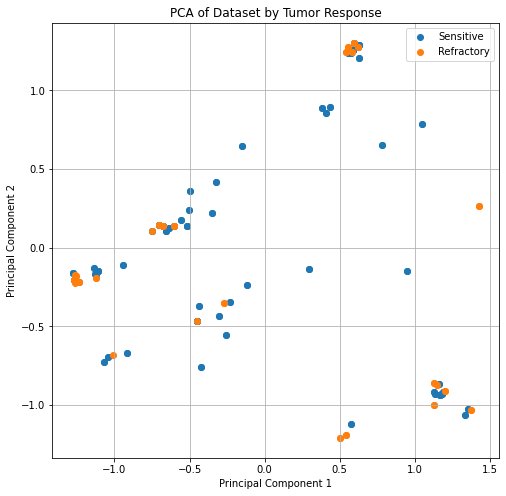

In [5]:
tumor_response = df['Tumor response']
source = df['Sample Source']
# location = df['Tumor Location Group']

# df_features = df.drop('Tumor response', axis=1)
df_features = df[['Patient Age', 'Patient Ethnicity','Patient Race','Neo-adjuvant','Other cancer diagnosis?','Tumor type','Tumor location','Tumor Grade','Tumor Stage','Tumor Substage','Sample type']]

# Identify categorical columns (excluding 'Tumor response')
categorical_cols = df_features.select_dtypes(include=['object', 'string']).columns
# Convert all categorical columns to string type
df_features[categorical_cols] = df_features[categorical_cols].astype(str)

# One-hot encode the categorical features
column_transformer = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(sparse=False), categorical_cols)],
    remainder='passthrough'
)

transformed_data = column_transformer.fit_transform(df_features)


# Apply PCA
pca = PCA(n_components=2)  # Adjust as needed
pca_result = pca.fit_transform(transformed_data)


# Create a PCA DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df.head()
# Plotting the PCA result, colored by 'Tumor response'

# Ensure pca_df retains the original index if it doesn't already
pca_df.index = df.index

# Plotting the PCA result, colored by 'Tumor response'
plt.figure(figsize=(8, 8))

# Iterate through each unique category in tumor_response
for category in tumor_response.unique():
    # Select indices for rows in this category
    category_indices = tumor_response[tumor_response == category].index
    # Select corresponding rows in pca_df
    subset = pca_df.loc[category_indices]
    # Plot these rows
    plt.scatter(subset['PCA1'], subset['PCA2'], label=category)


plt.title('PCA of Dataset by Tumor Response')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

/home/ozkilim/anaconda3/envs/clam/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


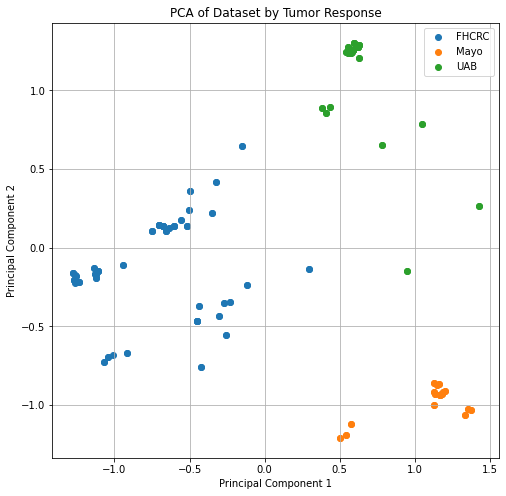

In [6]:
tumor_response = df['Tumor response']
source = df['Sample Source']
# location = df['Tumor Location Group']

# df_features = df.drop('Tumor response', axis=1)
df_features = df[['Patient Age', 'Patient Ethnicity','Patient Race','Neo-adjuvant','Other cancer diagnosis?','Tumor type','Tumor location','Tumor Grade','Tumor Stage','Tumor Substage','Sample type']]

# Identify categorical columns (excluding 'Tumor response')
categorical_cols = df_features.select_dtypes(include=['object', 'string']).columns

# Convert all categorical columns to string type
df_features[categorical_cols] = df_features[categorical_cols].astype(str)

# One-hot encode the categorical features
column_transformer = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(sparse=False), categorical_cols)],
    remainder='passthrough'
)

transformed_data = column_transformer.fit_transform(df_features)

# Apply PCA
pca = PCA(n_components=2)  # Adjust as needed
pca_result = pca.fit_transform(transformed_data)


# Create a PCA DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df.head()

# Ensure pca_df retains the original index if it doesn't already
pca_df.index = df.index

# Plotting the PCA result, colored by 'Tumor response'
plt.figure(figsize=(8, 8))

# Iterate through each unique category in tumor_response
for category in source.unique():
    # Select indices for rows in this category
    category_indices = source[source == category].index
    # Select corresponding rows in pca_df
    subset = pca_df.loc[category_indices]
    # Plot these rows
    plt.scatter(subset['PCA1'], subset['PCA2'], label=category)


plt.title('PCA of Dataset by Tumor Response')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


### Train and test with hospital hold out to see if can make any prediction for help out hospital from metadata. 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score



def one_hot(df_features):
    # Identify categorical columns (excluding 'Tumor response')
    categorical_cols = df_features.select_dtypes(include=['object', 'string']).columns.tolist()

    # Convert all categorical columns to string type
    df_features[categorical_cols] = df_features[categorical_cols].astype(str)

    # One-hot encode the categorical features
    column_transformer = ColumnTransformer(
        [('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols)],
        remainder='passthrough'
    )

    # Apply the transformations
    transformed_data = column_transformer.fit_transform(df_features)

    # Get new column names from the one-hot encoder
    new_columns = column_transformer.named_transformers_['one_hot_encoder'].get_feature_names_out(categorical_cols)

    # Combine with the names of the non-categorical (numeric) columns
    non_categorical_cols = df_features.drop(columns=categorical_cols).columns.tolist()
    all_new_columns = list(new_columns) + non_categorical_cols

    # Convert transformed data back to a DataFrame with new column names
    df_transformed = pd.DataFrame(transformed_data, columns=all_new_columns)

    return df_transformed



# Split the data based on 'Sample Source' values
sources = source.unique()


# binarize tumor resp. 

df_one_hot = one_hot(df[['Patient Age', 'Patient Ethnicity','Patient Race','Neo-adjuvant','Other cancer diagnosis?','Tumor response','Tumor type','Tumor location','Tumor Grade','Tumor Stage','Tumor Substage','Sample type','Sample Source']])
df_one_hot.head()


# Select two sources for training and one for testing
# For example, using sources[0] and sources[1] for training, sources[2] for testing
train_df = df_one_hot[df_one_hot['Sample Source_UAB']==1]
test_df = df_one_hot[df_one_hot['Sample Source_UAB']!=1]


print(train_df.shape)
print(test_df.shape)


y_train = train_df["Tumor response_Sensitive"]
X_train = train_df.drop(columns=['Tumor response_Sensitive','Tumor response_Refractory'])

y_test = test_df["Tumor response_Sensitive"]
X_test = test_df.drop(columns=['Tumor response_Sensitive','Tumor response_Refractory'])


# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy
accuracy = roc_auc_score(y_test, y_pred)
print(f"AUC: {accuracy:.2f}")

/home/ozkilim/anaconda3/envs/clam/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


(44, 89)
(130, 89)
AUC: 0.47
